In [1]:
#Installs Needed
#!pip install opencv-python
#!pip install pillow

In [2]:
print("Booting...")

Booting...


In [3]:
#os.getcwd()

In [4]:
import os
import concurrent.futures #Multithreading
from PIL import Image
import numpy as np

# Path to Image Folder
image_folder = "semantic_drone_dataset/training_set/images"
image_label_folder = "semantic_drone_dataset/training_set/gt/semantic/label_images"

# Create an empty list to store the loaded images
images = []
label_images = []

# Set the target size to which you want to resize the images
target_size = (600, 400)  # Resize OG Image Size: (6000,1000)


In [5]:
def load_and_process_image(filename, folder, file_extension):
    if filename.lower().endswith(file_extension):  # Check if the file has the correct extension
        image_path = os.path.join(folder, filename)
        with Image.open(image_path) as image:
            image = image.resize(target_size, Image.LANCZOS)
            return np.array(image)
    else:
        return None  # If it's not the correct file type, return None

In [6]:
# Function to load images using multiple threads
def load_images_concurrently(folder_path, file_extension):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Create a list of all files in the directory
        all_files = os.listdir(folder_path)
        # Use executor to apply 'load_and_process_image' to each file
        processed_images = list(executor.map(load_and_process_image, all_files, [folder_path]*len(all_files), [file_extension]*len(all_files)))
        # Remove None values from the list (for files that were not the correct type)
        return [image for image in processed_images if image is not None]

# Load images using threads
images = load_images_concurrently(image_folder, '.jpg')

# Load label images using threads
label_images = load_images_concurrently(image_label_folder, '.png')

# 'images' now contains NumPy arrays of all the .jpg images in the folder
# 'label_images' now contains NumPy arrays of all the .png label images in the folder

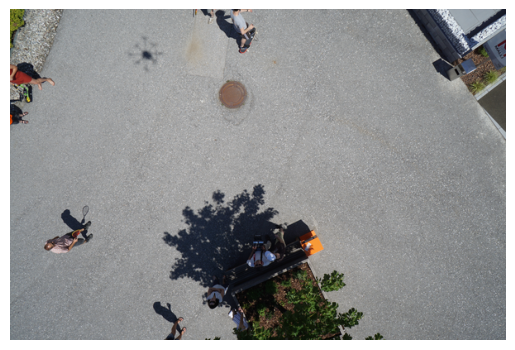

In [7]:
import matplotlib.pyplot as plt

# Display the first image
if images:
    plt.imshow(images[0])
    plt.axis('off')  # Remove axis labels
    plt.show()

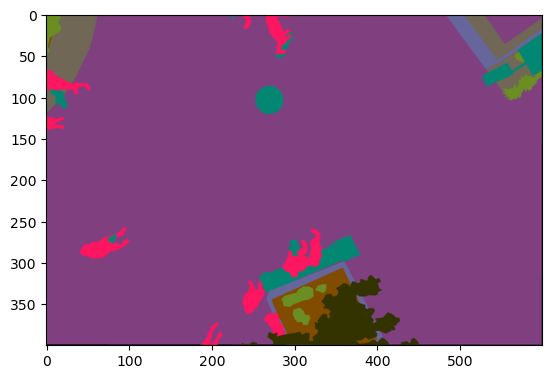

In [8]:
# Display the first label image
if label_images:
    plt.imshow(label_images[0])
    plt.show()

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the paths to your dataset
image_dir = 'semantic_drone_dataset/training_set/images'
label_dir = 'semantic_drone_dataset/training_set/gt/semantic/label_images'

# Load class definitions from the class_dict.csv
class_df = pd.read_csv('semantic_drone_dataset/training_set/gt/semantic/class_dict.csv', index_col=False, skipinitialspace=True)

# Map class names to RGB values
class_dict = {tuple(row[['r', 'g', 'b']].values): row['name'] for _, row in class_df.iterrows()}

In [ ]:
# Extract label codes and names
label_codes = [tuple(row[['r', 'g', 'b']].values) for _, row in class_df.iterrows()]
label_names = [class_dict[rgb] for rgb in label_codes]

# Load label images as grayscale images and preprocess them
label_images = []  # List to store label images

for label_filename in os.listdir(label_dir):
    if label_filename.endswith(".png"):
        label_path = os.path.join(label_dir, label_filename)
        label_image = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label_images.append(label_image)

# Convert label images to NumPy arrays
label_images = np.array(label_images)

In [ ]:
# Now, label_codes and label_names should be correctly populated
label_codes[:5], label_names[:5]

In [ ]:
# Split the data into training and validation sets
images_train, images_val, label_images_train, label_images_val = train_test_split(images, label_images, test_size=0.2, random_state=42)

In [ ]:
# Convert the data to NumPy arrays
X_train = np.array(images_train)
X_val = np.array(images_val)

# Define the number of classes (num_classes)
num_classes = len(label_names)

In [ ]:
# Define the input shape for your images
input_shape = target_size + (3,)  

# Define the model architecture
model = keras.Sequential()

# Add the first convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Add more convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Add Flatten layer to transition to a fully connected network
model.add(layers.Flatten())

# Add Dense layers for classification
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with num_classes units

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the batch size and number of epochs for training
batch_size = 32
epochs = 10

In [ ]:
# Convert label images to one-hot encoded labels
Y_train = to_categorical(label_images_train, num_classes=num_classes)
Y_val = to_categorical(label_images_val, num_classes=num_classes)

# Train the model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

In [ ]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_val, Y_val)

print(f'Test accuracy: {test_acc}')

In [ ]:
# You can save the model if needed
model.save('semantic_segmentation_model.h5')

In [ ]:
print("Done")